### **Plots for qualitative analysis - JSDs Analysis**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import pandas as pd

In [2]:
def plot_heatmap(d, idx=0, model='base'):
    sample_jsds = d[idx]['jsds']
    tokens = d[idx]['words']
    layers = np.arange(1, get_num_layers(model) + 1)
    question = d[idx]['question']
    context = d[idx]['context']

    # Create a DataFrame from the sample JSDS data
    data = []
    for i in layers:
        layer_data = []
        for token in np.arange(0, len(tokens)):
            value = sample_jsds[token].get(i, -1) * 100000
            # Apply log transformation to avoid issues with zero values
            if value == -1 * 100000:
                layer_data.append(np.nan)  # Use NaN to handle "exited early" cases
            else:
                layer_data.append(np.log1p(value))  # log1p handles log(1 + x) to avoid log(0) issue
        data.append(layer_data)

    df = pd.DataFrame(data, index=[f"Layer {i}" for i in layers], columns=tokens)

    # Plot the heatmap
    num_tokens = len(tokens)
    fig_width = max(10, num_tokens)  # Adjust the denominator for desired width scaling

    plt.figure(figsize=(fig_width, 10))
    heatmap = sns.heatmap(df, annot=False, fmt=".4f", cmap="Purples", cbar=True, linewidths=0.5, linecolor='gray')

    # Add custom annotations
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            value = df.iat[i, j]
            if np.isnan(value):
                heatmap.text(j + 0.5, i + 0.5, '•', color='red', ha='center', va='center', fontsize=12, fontweight='bold')
            else:
                heatmap.text(j + 0.5, i + 0.5, f'{value:.4f}', color='black', ha='center', va='center', fontsize=8)

    # Customize the color bar to indicate log scale
    cbar = heatmap.collections[0].colorbar
    cbar.set_label('Log(1 + JSD Value)')  # Customize the color bar label

    # Customize the plot
    plt.title(f'Heatmap of JSDS Values for Each Token\nQuestion: {question}', fontsize=16)
    plt.xlabel('Tokens', fontsize=12)
    plt.ylabel('Layers', fontsize=12)
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.show()

# Example of a get_num_layers function, you should replace it with the actual implementation
def get_num_layers(model):
    if model == 'base':
        return 12
    elif model == 'large':
        return 24
    else:
        raise ValueError("Unsupported model type")

In [3]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def parse_log(log_text, task='qa'):
    # Initialize the list to store all Q/A pairs
    qa_pairs = []

    # Split the log text into sections based on the '-END CONTEXT-' delimiter
    sections = log_text.strip().split('-END CONTEXT-')

    # Define regex patterns
    jsds_pattern = re.compile(r"JSDS:\s+{([^}]+)}")
    word_pattern = re.compile(r"Word:\s+(\S+)")
    
    if task == 'qa':
        question_pattern = re.compile(r"question:\s+(.*?)\s*context:")
        context_pattern = re.compile(r"context:\s+(.*)")
    elif task == 'translation':
        pass
    elif task == 'summarization':
        summarization_pattern = re.compile(r"summarize:\s+(.*)")
    else:
        raise ValueError(f"Invalid task: {task}")

    # Process each section separately
    for section in sections:
        section = section.strip()  # Clean up leading/trailing whitespace

        if not section:
            continue
        
        if task == 'qa': 
            # Extract question
            question_match = question_pattern.search(section)
            question = question_match.group(1).strip() if question_match else None

            # Extract context
            context_match = context_pattern.search(section)
            context = context_match.group(1).strip() if context_match else None
        elif task == 'summarization':
            summarization_match = summarization_pattern.search(section)
            question = None
            context = summarization_match.group(1).strip() if summarization_match else None
        elif task == 'translation':
            pass
        else:
            raise ValueError(f"Invalid task: {task}")

        # Extract all JSDS
        jsds_matches = jsds_pattern.findall(section)
        jsds_list = {}
        for i, jsds in enumerate(jsds_matches):
            layer_jsds = re.findall(r"(\d+):\s*tensor\(([\d\.e-]+),", jsds)
            jsds_dict = {int(layer): float(value) for layer, value in layer_jsds}
            jsds_list[i] = jsds_dict

        # Extract all words
        word_matches = word_pattern.findall(section)
        words = [match if match != "Token_id:" else ' ' for match in word_matches]  # Handle whitespace tokens

        # Add the Q/A pair to the list
        qa_pairs.append({
            'question': question,
            'context': context,
            'jsds': jsds_list,
            'words': words
        })

    return qa_pairs

In [ ]:
import re
import numpy as np

def parse_log(log_text, task='qa'):
    # Initialize the list to store all Q/A pairs
    qa_pairs = []

    # Split the log text into sections based on the '-END CONTEXT-' delimiter
    sections = log_text.strip().split('-END CONTEXT-')

    # Define regex patterns
    jsds_pattern = re.compile(r"JSDS:\s+{([^}]+)}")
    word_pattern = re.compile(r"Word:\s+(\S+)")
    
    if task == 'qa':
        question_pattern = re.compile(r"question:\s+(.*?)\s*context:")
        context_pattern = re.compile(r"context:\s+(.*)")
    elif task == 'translation':
        pass
    elif task == 'summarization':
        summarization_pattern = re.compile(r"summarize:\s+(.*)")
    else:
        raise ValueError(f"Invalid task: {task}")

    # Process each section separately
    for section in sections:
        section = section.strip()  # Clean up leading/trailing whitespace

        if not section:
            continue
        
        if task == 'qa': 
            # Extract question
            question_match = question_pattern.search(section)
            question = question_match.group(1).strip() if question_match else None

            # Extract context
            context_match = context_pattern.search(section)
            context = context_match.group(1).strip() if context_match else None
        elif task == 'summarization':
            summarization_match = summarization_pattern.search(section)
            question = None
            context = summarization_match.group(1).strip() if summarization_match else None
        elif task == 'translation':
            pass
        else:
            raise ValueError(f"Invalid task: {task}")

        # Extract all JSDS
        jsds_matches = jsds_pattern.findall(section)
        jsds_list = {}
        for i, jsds in enumerate(jsds_matches):
            layer_jsds = re.findall(r"(\d+):\s*tensor\(([\d\.e-]+),", jsds)
            jsds_dict = {int(layer): float(value) for layer, value in layer_jsds}
            jsds_list[i] = jsds_dict

        # Extract all words
        word_matches = word_pattern.findall(section)
        words = [match if match != "Token_id:" else ' ' for match in word_matches]  # Handle whitespace tokens

        # Add the Q/A pair to the list
        qa_pairs.append({
            'question': question,
            'context': context,
            'jsds': jsds_list,
            'words': words
        })

    return qa_pairs

def average_exiting_layer_per_position(qa_pairs):
    max_layers_per_position = {}

    for qa in qa_pairs:
        jsds_list = qa['jsds']
        for token, layers in jsds_list.items():
            max_layer = max(layers.keys()) if layers else 0
            if token not in max_layers_per_position:
                max_layers_per_position[token] = []
            max_layers_per_position[token].append(max_layer)
    
    average_exits = {token: np.mean(layers) for token, layers in max_layers_per_position.items()}
    return average_exits

In [4]:
log_text = '/Users/joanvelja/Documents/GitHub/Confidently_Exiting/src/hello.txt'
with open(log_text, 'r') as file:
    log_text = file.read()

log_text = log_text.split('*** Evaluate ***')[1]

In [5]:
qa_pairs = parse_log(log_text, task='qa')

In [6]:
qa_pairs[1]

{'question': 'Which NFL team represented the NFC at Super Bowl 50?',
 'context': 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.',
 'jsds': {0: {2: 0.0136,
   3: 0.0143,
   4: 0.0152,
   5: 0.0161,
   6: 0.0172,
   7: 0.0184,
   8: 0.0198,
   9: 0.0215,
   10: 0.0234,
 

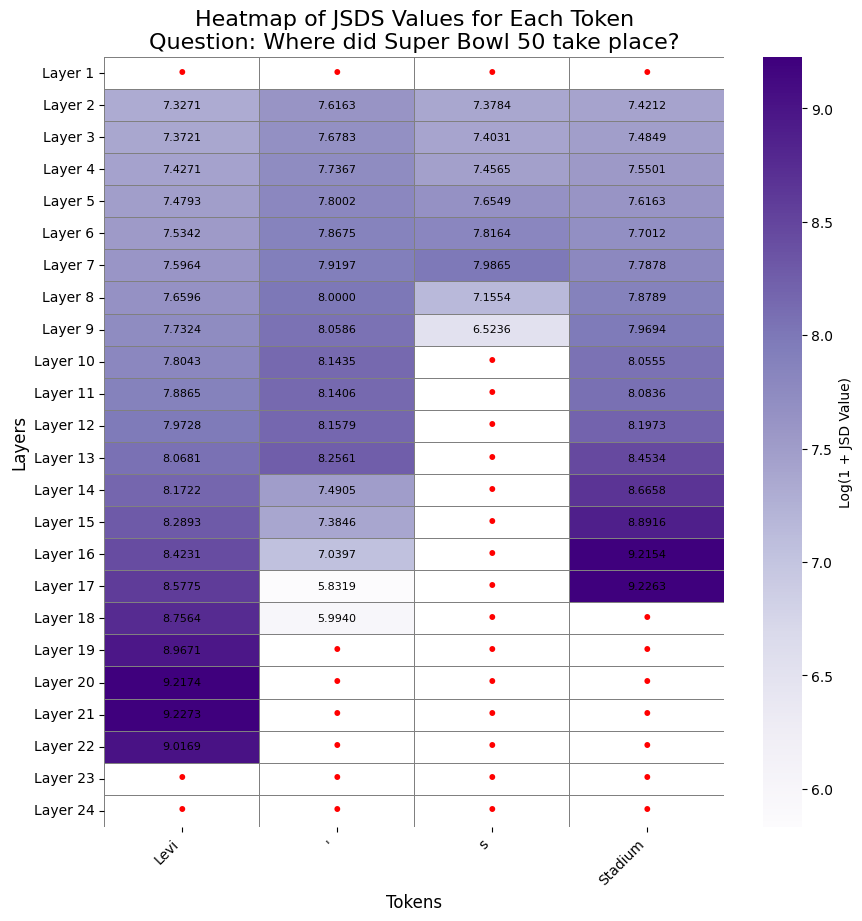

In [7]:
plot_heatmap(qa_pairs, idx=2, model='large')